# How much data do I need at least?

Use it to check if we have a sufficient amount of data collected for our own dataset.

## For FastAI

*Martina Brachmann <martina.brachmann(at)ri(dot)se>* <br>
*Michael Stein <stein.informatik(at)gmail(dot)com*

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
'''
We create a new metric.
We just want to have the current dataset size in the csv file. Hence, nothing
exciting here.
'''

class DataSetSize(Callback):
  def __init__(self, value):
    super().__init__()
    self.name = "dataset_size"
    self.value = value

  def on_epoch_begin(self, **kwargs):
    pass
        
  def on_epoch_end(self, last_metrics, **kwargs):
    return add_metrics(last_metrics, self.value)

In [0]:
'''
The magic happens here. 

We split all the images we have in *portions_*, create a new databunch and train
our network for *fit_one_cycle_*. After training, we take the next bigger portion 
and create a new databunch and train our network again. We continue until our 
databunch includes all images. 
In order to increase variance, we create new portions *kfolds_*. Thus, we take 
all of our images, shuffle them, create a new portion and train the network. We 
also forget the trained model before each *kfolds_*.
We save the information retrieved for each training in a seperate csv file. Thus,
in case the process stops our we have to add more kfolds we can just continue 
with the information we have already collected and don't have to start from the 
beginning. To do this, change the values for *portion_start_* and *kfold_start_*
to a value other than '0'.
The parameter *model_* expects the model, *tfms_* the transformation, *path_* the 
path to the images in Posix format and *pat_* the pattern for the label. This, 
however, may change in the future.
'''

from random import shuffle
from fastai.callbacks.csv_logger import CSVLogger
from fastai.metrics import error_rate, accuracy

def adaptive_training(path_, fnames_, pat_, tfms_, model_, portions_=10, kfolds_=5, portion_start_=0, kfold_start_=0, valid_pct_=0.2, fit_one_cycle_=1):
  
  print('Grab a coffee, this may take a while...\n')

  
  def estimate_batch_size(len_data_batch, max_bs=64):
    if len_data_batch * valid_pct_ > max_bs:
      return int(max_bs)
    else:
      return estimate_batch_size(len_data_batch, max_bs=max_bs/2)
    
  portions = range(portions_)
  kfolds = range(kfolds_)
  
  for i in portions[portion_start_:]:
    
    print("Portion %s" % (i))
    
    acc = []
    for j in kfolds[kfold_start_:]: 
      slice_upper = int((len(fnames_) * (i+1)) / portions_)
      shuffle(fnames_)
      fname_sub = fnames_[:slice_upper]
      
      bs = estimate_batch_size(len(fname_sub))
      np.random.seed(random.randint(0, 2**16))
      data = ImageDataBunch.from_name_re(path=path, fnames=fname_sub, pat=pat_, valid_pct=valid_pct_, ds_tfms=tfms_, size=224, bs=bs).normalize(imagenet_stats)
      learn = cnn_learner(data, model_, metrics=[error_rate, accuracy, DataSetSize(slice_upper)], callback_fns=[CSVLogger])
      learn.model
      learn.fit_one_cycle(fit_one_cycle_)

      df = learn.csv_logger.read_logged_file()
      
      filename = "history_portion-" + str(i) + "_kfold-" + str(j) + ".csv"
      source = Path(path_/'history.csv')
      target = Path(path_/filename)
      source.rename(target)

In [0]:
'''
Get the path of the images.
'''

path = Path(root_dir + 'data-sets/faces_fake-vs-real');
#path = untar_data(URLs.PETS)
print(path)
fnames = get_image_files(path)
#path_img = path/'images'
#fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

/content/gdrive/My Drive/data-sets/faces_fake-vs-real
1200


[PosixPath('/content/gdrive/My Drive/data-sets/faces_fake-vs-real/fake_199.jpeg'),
 PosixPath('/content/gdrive/My Drive/data-sets/faces_fake-vs-real/fake_200.jpeg'),
 PosixPath('/content/gdrive/My Drive/data-sets/faces_fake-vs-real/real_181.jpeg'),
 PosixPath('/content/gdrive/My Drive/data-sets/faces_fake-vs-real/real_182.jpeg'),
 PosixPath('/content/gdrive/My Drive/data-sets/faces_fake-vs-real/real_183.jpeg')]

In [0]:
pat = r'/([^/]+)_\d+.jpeg$'
#pat = r'/([^/]+)_\d+.jpg$'
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=0.05, max_warp=0.)
tfms = get_transforms()

In [0]:
'''
Start the process
'''
adaptive_training(path, fnames, pat, tfms, models.resnet34, portions_=20, kfolds_=5, portion_start_=0, kfold_start_=0, fit_one_cycle_=4)

Grab a coffee, this may take a while...

Portion 0


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.829187,0.646655,0.333333,0.666667,60,00:08
1,0.689260,0.472651,0.250000,0.750000,60,00:04
2,0.614404,0.460048,0.166667,0.833333,60,00:04
3,0.579306,0.431334,0.166667,0.833333,60,00:04


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.798173,0.526898,0.250000,0.750000,60,00:09
1,0.743223,0.442637,0.333333,0.666667,60,00:04
2,0.650387,0.354848,0.166667,0.833333,60,00:04
3,0.524838,0.370309,0.250000,0.750000,60,00:04


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.941740,0.595056,0.250000,0.750000,60,00:10
1,0.843625,0.569750,0.166667,0.833333,60,00:03
2,0.697010,0.630011,0.166667,0.833333,60,00:04
3,0.583867,0.623994,0.250000,0.750000,60,00:03


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.965357,0.950966,0.750000,0.250000,60,00:06
1,0.888493,0.989995,0.583333,0.416667,60,00:04
2,0.728321,0.937587,0.583333,0.416667,60,00:04
3,0.642230,0.883898,0.416667,0.583333,60,00:04


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.781290,1.041782,0.833333,0.166667,60,00:08
1,0.787921,1.142350,0.750000,0.250000,60,00:04
2,0.617207,1.125760,0.500000,0.500000,60,00:04
3,0.537874,1.067814,0.500000,0.500000,60,00:04


Portion 1


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.854080,0.897705,0.375000,0.625000,120,00:16
1,0.833365,0.509443,0.250000,0.750000,120,00:07
2,0.683076,0.485902,0.166667,0.833333,120,00:07
3,0.560121,0.459848,0.166667,0.833333,120,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.957336,0.520806,0.208333,0.791667,120,00:17
1,0.783264,0.523059,0.250000,0.750000,120,00:07
2,0.657126,0.569438,0.291667,0.708333,120,00:07
3,0.555667,0.459571,0.166667,0.833333,120,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.836563,0.603133,0.208333,0.791667,120,00:14
1,0.685500,0.517392,0.166667,0.833333,120,00:07
2,0.565072,0.535112,0.208333,0.791667,120,00:07
3,0.485434,0.558272,0.208333,0.791667,120,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.923262,0.737639,0.458333,0.541667,120,00:12
1,0.783931,0.734281,0.500000,0.500000,120,00:07
2,0.630154,0.953733,0.500000,0.500000,120,00:07
3,0.513085,1.014226,0.500000,0.500000,120,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.773138,0.856976,0.500000,0.500000,120,00:12
1,0.682552,0.852415,0.333333,0.666667,120,00:07
2,0.575987,0.904327,0.333333,0.666667,120,00:07
3,0.509007,0.888538,0.375000,0.625000,120,00:07


Portion 2


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.977777,0.490820,0.250000,0.750000,180,00:17
1,0.806355,0.861387,0.361111,0.638889,180,00:11
2,0.661857,1.244922,0.472222,0.527778,180,00:10
3,0.612105,1.235079,0.388889,0.611111,180,00:10


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.972338,0.801353,0.472222,0.527778,180,00:14
1,0.779431,0.823733,0.444444,0.555556,180,00:10
2,0.654340,0.873726,0.416667,0.583333,180,00:10
3,0.576539,0.874397,0.388889,0.611111,180,00:10


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.847897,0.673626,0.444444,0.555556,180,00:13
1,0.723372,0.539064,0.333333,0.666667,180,00:10
2,0.622349,0.544135,0.305556,0.694444,180,00:10
3,0.576984,0.587072,0.333333,0.666667,180,00:10


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.838105,0.781260,0.388889,0.611111,180,00:15
1,0.817818,0.999419,0.444444,0.555556,180,00:10
2,0.726951,1.109645,0.500000,0.500000,180,00:10
3,0.648636,1.188698,0.444444,0.555556,180,00:10


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,1.056622,0.596427,0.277778,0.722222,180,00:12
1,0.847755,0.575496,0.250000,0.750000,180,00:11
2,0.770012,0.697163,0.333333,0.666667,180,00:10
3,0.689419,0.798652,0.388889,0.611111,180,00:10


Portion 3


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.931129,0.747536,0.500000,0.500000,240,00:17
1,0.733613,0.702887,0.375000,0.625000,240,00:14
2,0.636281,0.804116,0.375000,0.625000,240,00:14
3,0.561714,0.806844,0.395833,0.604167,240,00:14


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,1.000910,0.710160,0.395833,0.604167,240,00:17
1,0.809573,0.659566,0.291667,0.708333,240,00:14
2,0.638272,0.775810,0.291667,0.708333,240,00:14
3,0.545917,0.735610,0.333333,0.666667,240,00:14


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.864478,0.711475,0.500000,0.500000,240,00:16
1,0.687707,0.733979,0.312500,0.687500,240,00:14
2,0.610300,1.028734,0.375000,0.625000,240,00:14
3,0.530734,1.011911,0.395833,0.604167,240,00:14


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.921263,0.802847,0.416667,0.583333,240,00:15
1,0.803459,0.638170,0.291667,0.708333,240,00:14
2,0.666597,0.625695,0.270833,0.729167,240,00:14
3,0.591577,0.610996,0.250000,0.750000,240,00:14


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.918635,0.674203,0.416667,0.583333,240,00:16
1,0.774020,0.708210,0.375000,0.625000,240,00:14
2,0.639841,0.833362,0.312500,0.687500,240,00:14
3,0.552377,0.851457,0.312500,0.687500,240,00:14


Portion 4


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.850602,0.585572,0.283333,0.716667,300,00:20
1,0.728326,0.506502,0.250000,0.750000,300,00:16
2,0.642391,0.486571,0.266667,0.733333,300,00:16
3,0.536956,0.494514,0.250000,0.750000,300,00:16


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.879268,0.813113,0.500000,0.500000,300,00:18
1,0.803404,0.975740,0.466667,0.533333,300,00:17
2,0.672573,0.895695,0.366667,0.633333,300,00:16
3,0.593539,0.877163,0.366667,0.633333,300,00:16


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.872022,0.807817,0.383333,0.616667,300,00:17
1,0.789154,0.730023,0.350000,0.650000,300,00:17
2,0.666910,0.676682,0.333333,0.666667,300,00:17
3,0.579117,0.631991,0.350000,0.650000,300,00:16


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.916409,0.628474,0.316667,0.683333,300,00:17
1,0.754796,0.557890,0.250000,0.750000,300,00:17
2,0.633056,0.505232,0.250000,0.750000,300,00:17
3,0.596671,0.479052,0.233333,0.766667,300,00:17


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.839031,0.628277,0.350000,0.650000,300,00:17
1,0.759524,0.776501,0.366667,0.633333,300,00:17
2,0.658608,0.785179,0.416667,0.583333,300,00:17
3,0.573919,0.790750,0.433333,0.566667,300,00:16


Portion 5


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.932370,1.215337,0.500000,0.500000,360,00:20
1,0.793635,0.920889,0.333333,0.666667,360,00:20
2,0.677962,0.860847,0.416667,0.583333,360,00:19
3,0.630798,0.853772,0.375000,0.625000,360,00:19


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.961170,0.695881,0.430556,0.569444,360,00:20
1,0.775097,0.586390,0.319444,0.680556,360,00:20
2,0.706126,0.663322,0.361111,0.638889,360,00:20
3,0.658900,0.702731,0.361111,0.638889,360,00:20


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.922654,0.647315,0.361111,0.638889,360,00:20
1,0.786010,0.609663,0.333333,0.666667,360,00:20
2,0.697949,0.760151,0.375000,0.625000,360,00:20
3,0.621994,0.788646,0.388889,0.611111,360,00:20


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.914707,0.774035,0.430556,0.569444,360,00:20
1,0.765035,0.548798,0.236111,0.763889,360,00:20
2,0.682892,0.634915,0.333333,0.666667,360,00:20
3,0.634052,0.661212,0.291667,0.708333,360,00:20


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,1.033477,0.894504,0.555556,0.444444,360,00:20
1,0.815993,0.762454,0.458333,0.541667,360,00:20
2,0.712440,0.713208,0.347222,0.652778,360,00:20
3,0.639858,0.673712,0.277778,0.722222,360,00:20


Portion 6


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.955670,0.774512,0.416667,0.583333,420,00:26
1,0.802604,0.731153,0.285714,0.714286,420,00:25
2,0.692664,0.708252,0.321429,0.678571,420,00:25
3,0.618650,0.683518,0.285714,0.714286,420,00:25


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.813261,0.772326,0.380952,0.619048,420,00:25
1,0.710901,0.661183,0.238095,0.761905,420,00:25
2,0.581180,0.629531,0.250000,0.750000,420,00:25
3,0.518374,0.630509,0.261905,0.738095,420,00:25


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.927094,0.818135,0.511905,0.488095,420,00:25
1,0.813620,0.716256,0.345238,0.654762,420,00:25
2,0.681667,0.661627,0.285714,0.714286,420,00:25
3,0.618340,0.619479,0.285714,0.714286,420,00:25


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,1.098774,0.688710,0.380952,0.619048,420,00:25
1,0.896067,0.617539,0.285714,0.714286,420,00:25
2,0.758661,0.661101,0.333333,0.666667,420,00:25
3,0.674873,0.593160,0.297619,0.702381,420,00:25


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.926810,0.746215,0.428571,0.571429,420,00:25
1,0.774045,0.622761,0.321429,0.678571,420,00:24
2,0.672094,0.606639,0.250000,0.750000,420,00:25
3,0.605054,0.576487,0.250000,0.750000,420,00:25


Portion 7


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.896254,0.772768,0.479167,0.520833,480,00:27
1,0.768448,0.630939,0.250000,0.750000,480,00:27
2,0.664668,0.593085,0.218750,0.781250,480,00:27
3,0.605009,0.542335,0.239583,0.760417,480,00:27


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.819893,0.646860,0.385417,0.614583,480,00:28
1,0.709447,0.731939,0.333333,0.666667,480,00:28
2,0.624279,0.703102,0.250000,0.750000,480,00:28
3,0.557574,0.689008,0.260417,0.739583,480,00:27


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.894283,0.649100,0.291667,0.708333,480,00:28
1,0.742252,0.598098,0.270833,0.729167,480,00:28
2,0.643962,0.570333,0.218750,0.781250,480,00:28
3,0.579015,0.578264,0.229167,0.770833,480,00:28


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.893416,0.697755,0.385417,0.614583,480,00:28
1,0.787788,0.659130,0.302083,0.697917,480,00:28
2,0.715832,0.573896,0.302083,0.697917,480,00:28
3,0.644395,0.554279,0.291667,0.708333,480,00:28


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.884147,0.708436,0.343750,0.656250,480,00:28
1,0.756009,0.834903,0.364583,0.635417,480,00:28
2,0.657462,0.809058,0.302083,0.697917,480,00:28
3,0.583590,0.750908,0.281250,0.718750,480,00:28


Portion 8


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.908391,0.644812,0.361111,0.638889,540,00:29
1,0.787624,0.600845,0.314815,0.685185,540,00:28
2,0.691911,0.606000,0.296296,0.703704,540,00:29
3,0.623942,0.619043,0.296296,0.703704,540,00:28


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.929866,0.767790,0.444444,0.555556,540,00:29
1,0.801719,0.881983,0.444444,0.555556,540,00:28
2,0.719662,0.890061,0.388889,0.611111,540,00:28
3,0.667721,0.865958,0.351852,0.648148,540,00:28


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.865787,0.699826,0.388889,0.611111,540,00:28
1,0.749363,0.780084,0.379630,0.620370,540,00:28
2,0.663790,0.804336,0.416667,0.583333,540,00:28
3,0.619205,0.739489,0.416667,0.583333,540,00:28


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.874051,0.615125,0.305556,0.694444,540,00:28
1,0.732648,0.557420,0.259259,0.740741,540,00:28
2,0.634201,0.544824,0.240741,0.759259,540,00:29
3,0.581082,0.519487,0.212963,0.787037,540,00:28


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.870811,0.699510,0.407407,0.592593,540,00:28
1,0.755779,0.635812,0.296296,0.703704,540,00:28
2,0.671792,0.567693,0.268519,0.731481,540,00:28
3,0.600805,0.535290,0.259259,0.740741,540,00:29


Portion 9


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.858521,0.684550,0.391667,0.608333,600,00:35
1,0.737495,0.766552,0.341667,0.658333,600,00:34
2,0.659847,0.708247,0.358333,0.641667,600,00:34
3,0.581179,0.672748,0.316667,0.683333,600,00:34


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.854563,0.770964,0.375000,0.625000,600,00:34
1,0.711397,0.912724,0.400000,0.600000,600,00:34
2,0.622022,0.815951,0.366667,0.633333,600,00:33
3,0.567646,0.707879,0.341667,0.658333,600,00:34


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.848728,0.859859,0.466667,0.533333,600,00:33
1,0.743628,0.697608,0.308333,0.691667,600,00:33
2,0.643485,0.645674,0.258333,0.741667,600,00:34
3,0.580558,0.583162,0.233333,0.766667,600,00:34


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.934432,0.694091,0.375000,0.625000,600,00:33
1,0.761275,0.667374,0.291667,0.708333,600,00:33
2,0.672586,0.555405,0.233333,0.766667,600,00:33
3,0.602762,0.528102,0.208333,0.791667,600,00:33


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.829307,0.602833,0.283333,0.716667,600,00:33
1,0.667928,0.659443,0.350000,0.650000,600,00:33
2,0.610460,0.685027,0.341667,0.658333,600,00:33
3,0.560754,0.660522,0.283333,0.716667,600,00:33


Portion 10


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.910504,0.689180,0.386364,0.613636,660,00:36
1,0.765488,0.617415,0.303030,0.696970,660,00:36
2,0.677242,0.681448,0.303030,0.696970,660,00:37
3,0.605987,0.686823,0.295455,0.704545,660,00:36


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.901096,0.747591,0.393939,0.606061,660,00:37
1,0.719870,0.940311,0.371212,0.628788,660,00:37
2,0.621793,0.786966,0.295455,0.704545,660,00:37
3,0.564819,0.720552,0.303030,0.696970,660,00:37


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.884188,0.605198,0.325758,0.674242,660,00:36
1,0.770109,0.675981,0.280303,0.719697,660,00:36
2,0.677759,0.661318,0.257576,0.742424,660,00:37
3,0.597654,0.591726,0.250000,0.750000,660,00:37


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.834712,0.950978,0.446970,0.553030,660,00:37
1,0.738535,0.873265,0.325758,0.674242,660,00:37
2,0.643344,0.896740,0.333333,0.666667,660,00:37
3,0.571956,0.860304,0.340909,0.659091,660,00:36


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.976393,0.656708,0.386364,0.613636,660,00:36
1,0.783871,0.667670,0.333333,0.666667,660,00:36
2,0.639060,0.708367,0.340909,0.659091,660,00:36
3,0.576169,0.689319,0.310606,0.689394,660,00:36


Portion 11


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.853826,0.621451,0.340278,0.659722,720,00:41
1,0.703954,0.695360,0.312500,0.687500,720,00:42
2,0.624442,0.736541,0.298611,0.701389,720,00:42
3,0.555210,0.706645,0.277778,0.722222,720,00:42


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.910601,0.582930,0.312500,0.687500,720,00:42
1,0.749895,0.668870,0.326389,0.673611,720,00:42
2,0.650689,0.585331,0.263889,0.736111,720,00:42
3,0.579660,0.556734,0.236111,0.763889,720,00:42


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.913509,0.674988,0.333333,0.666667,720,00:42
1,0.739673,0.675439,0.284722,0.715278,720,00:42
2,0.644046,0.571912,0.236111,0.763889,720,00:42
3,0.586397,0.550483,0.236111,0.763889,720,00:42


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.909090,0.635382,0.277778,0.722222,720,00:42
1,0.730195,0.827406,0.319444,0.680556,720,00:42
2,0.654314,0.661131,0.305556,0.694444,720,00:42
3,0.584344,0.607438,0.291667,0.708333,720,00:42


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.834778,0.703640,0.340278,0.659722,720,00:42
1,0.744194,0.694343,0.284722,0.715278,720,00:42
2,0.660654,0.507643,0.250000,0.750000,720,00:42
3,0.595266,0.481757,0.250000,0.750000,720,00:42


Portion 12


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.892653,0.748501,0.358974,0.641026,780,00:43
1,0.723068,0.725795,0.314103,0.685897,780,00:42
2,0.628594,0.721765,0.307692,0.692308,780,00:43
3,0.563730,0.660794,0.269231,0.730769,780,00:43


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.848800,0.648437,0.358974,0.641026,780,00:43
1,0.715505,0.614801,0.326923,0.673077,780,00:43
2,0.623022,0.580434,0.301282,0.698718,780,00:43
3,0.563570,0.556458,0.282051,0.717949,780,00:43


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.811031,0.688810,0.371795,0.628205,780,00:43
1,0.698324,0.740915,0.326923,0.673077,780,00:43
2,0.636029,0.712397,0.346154,0.653846,780,00:43
3,0.582195,0.665146,0.326923,0.673077,780,00:43


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.824823,0.472675,0.224359,0.775641,780,00:43
1,0.680193,0.449787,0.237179,0.762821,780,00:43
2,0.605522,0.519528,0.262821,0.737179,780,00:43
3,0.548992,0.509664,0.256410,0.743590,780,00:43


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.816624,0.647351,0.352564,0.647436,780,00:43
1,0.692113,0.668211,0.275641,0.724359,780,00:43
2,0.608979,0.557499,0.230769,0.769231,780,00:43
3,0.559115,0.547454,0.243590,0.756410,780,00:43


Portion 13


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.859423,0.656091,0.297619,0.702381,840,00:47
1,0.728976,0.666040,0.309524,0.690476,840,00:46
2,0.649405,0.637030,0.285714,0.714286,840,00:46
3,0.583808,0.602495,0.250000,0.750000,840,00:46


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.838852,0.726873,0.327381,0.672619,840,00:46
1,0.714446,0.670815,0.285714,0.714286,840,00:46
2,0.633289,0.634259,0.291667,0.708333,840,00:46
3,0.583988,0.605526,0.309524,0.690476,840,00:46


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.871443,0.667286,0.375000,0.625000,840,00:46
1,0.751754,0.631867,0.291667,0.708333,840,00:46
2,0.651332,0.574698,0.250000,0.750000,840,00:46
3,0.594792,0.535509,0.255952,0.744048,840,00:46


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.905586,0.495753,0.261905,0.738095,840,00:46
1,0.743534,0.446561,0.202381,0.797619,840,00:46
2,0.638152,0.467027,0.226190,0.773810,840,00:46
3,0.577589,0.468388,0.238095,0.761905,840,00:45


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.824081,0.558236,0.297619,0.702381,840,00:46
1,0.711929,0.520140,0.214286,0.785714,840,00:46
2,0.644505,0.565476,0.220238,0.779762,840,00:46
3,0.559275,0.565778,0.214286,0.785714,840,00:46


Portion 14


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.842338,0.605610,0.316667,0.683333,900,00:53
1,0.724013,0.569440,0.261111,0.738889,900,00:52
2,0.628058,0.512775,0.222222,0.777778,900,00:52
3,0.572556,0.493626,0.216667,0.783333,900,00:52


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.893410,0.569425,0.277778,0.722222,900,00:52
1,0.744017,0.540305,0.272222,0.727778,900,00:51
2,0.630527,0.501862,0.233333,0.766667,900,00:51
3,0.580439,0.475638,0.222222,0.777778,900,00:52


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.792762,0.560116,0.288889,0.711111,900,00:52
1,0.712406,0.596370,0.266667,0.733333,900,00:52
2,0.619799,0.509192,0.216667,0.783333,900,00:52
3,0.564893,0.486686,0.227778,0.772222,900,00:51


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.825173,0.593290,0.311111,0.688889,900,00:51
1,0.708460,0.577392,0.283333,0.716667,900,00:51
2,0.629469,0.591282,0.255556,0.744444,900,00:51
3,0.560755,0.574532,0.272222,0.727778,900,00:51


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.940505,0.579475,0.283333,0.716667,900,00:51
1,0.749062,0.648122,0.266667,0.733333,900,00:52
2,0.637273,0.586692,0.272222,0.727778,900,00:52
3,0.554964,0.556950,0.255556,0.744444,900,00:54


Portion 15


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.841320,0.715577,0.380208,0.619792,960,00:56
1,0.696392,0.669585,0.286458,0.713542,960,00:55
2,0.610793,0.615147,0.276042,0.723958,960,00:55
3,0.556273,0.578160,0.244792,0.755208,960,00:55


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.841253,0.693871,0.354167,0.645833,960,00:55
1,0.669458,0.667811,0.281250,0.718750,960,00:56
2,0.609424,0.623965,0.270833,0.729167,960,00:55
3,0.565545,0.623872,0.296875,0.703125,960,00:54


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.765623,0.629631,0.317708,0.682292,960,00:55
1,0.662725,0.660875,0.302083,0.697917,960,00:54
2,0.584096,0.638780,0.291667,0.708333,960,00:55
3,0.545376,0.618590,0.286458,0.713542,960,00:55


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.784451,0.611692,0.302083,0.697917,960,00:56
1,0.652309,0.610779,0.281250,0.718750,960,00:56
2,0.576927,0.617952,0.260417,0.739583,960,00:56
3,0.522054,0.621927,0.260417,0.739583,960,00:56


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.798917,0.547098,0.255208,0.744792,960,00:55
1,0.687057,0.473109,0.213542,0.786458,960,00:55
2,0.584768,0.427803,0.182292,0.817708,960,00:55
3,0.531984,0.405867,0.171875,0.828125,960,00:55


Portion 16


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.853506,0.603422,0.274510,0.725490,1020,00:56
1,0.716591,0.626291,0.269608,0.730392,1020,00:55
2,0.630798,0.510475,0.230392,0.769608,1020,00:56
3,0.566661,0.499143,0.240196,0.759804,1020,00:55


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.889671,0.558228,0.264706,0.735294,1020,00:56
1,0.764545,0.474013,0.210784,0.789216,1020,00:56
2,0.666339,0.401917,0.142157,0.857843,1020,00:56
3,0.603870,0.394999,0.166667,0.833333,1020,00:56


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.751916,0.664813,0.313726,0.686275,1020,00:56
1,0.678368,0.603034,0.274510,0.725490,1020,00:56
2,0.592835,0.539503,0.230392,0.769608,1020,00:55
3,0.528531,0.523843,0.230392,0.769608,1020,00:56


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.879349,0.702163,0.357843,0.642157,1020,00:56
1,0.756375,0.563971,0.259804,0.740196,1020,00:55
2,0.660889,0.480967,0.215686,0.784314,1020,00:55
3,0.588397,0.454009,0.205882,0.794118,1020,00:55


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.851192,0.780190,0.377451,0.622549,1020,00:55
1,0.688975,0.585066,0.274510,0.725490,1020,00:54
2,0.601796,0.583661,0.259804,0.740196,1020,00:55
3,0.549740,0.570490,0.245098,0.754902,1020,00:56


Portion 17


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.814847,0.554645,0.287037,0.712963,1080,01:03
1,0.683854,0.454311,0.217593,0.782407,1080,01:02
2,0.596171,0.421990,0.208333,0.791667,1080,01:01
3,0.545016,0.428193,0.199074,0.800926,1080,01:01


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.870629,0.567073,0.245370,0.754630,1080,01:01
1,0.721982,0.609449,0.250000,0.750000,1080,01:01
2,0.626018,0.572276,0.240741,0.759259,1080,01:00
3,0.580364,0.526959,0.231481,0.768519,1080,01:01


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.826753,0.605330,0.310185,0.689815,1080,01:01
1,0.712949,0.549844,0.254630,0.745370,1080,01:00
2,0.631409,0.548117,0.259259,0.740741,1080,01:01
3,0.586535,0.537019,0.259259,0.740741,1080,01:01


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.864522,0.614300,0.310185,0.689815,1080,01:02
1,0.722706,0.629792,0.287037,0.712963,1080,01:01
2,0.635497,0.607406,0.273148,0.726852,1080,01:00
3,0.563993,0.572921,0.254630,0.745370,1080,01:01


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.833796,0.671094,0.356481,0.643519,1080,01:01
1,0.725313,0.634645,0.291667,0.708333,1080,01:02
2,0.618965,0.559726,0.254630,0.745370,1080,01:00
3,0.553626,0.532769,0.250000,0.750000,1080,01:00


Portion 18


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.826314,0.646045,0.337719,0.662281,1140,01:05
1,0.713864,0.630298,0.298246,0.701754,1140,01:04
2,0.617441,0.585130,0.245614,0.754386,1140,01:04
3,0.538127,0.576291,0.250000,0.750000,1140,01:05


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.841695,0.655385,0.293860,0.706140,1140,01:05
1,0.734015,0.571588,0.289474,0.710526,1140,01:05
2,0.627519,0.523365,0.236842,0.763158,1140,01:05
3,0.571692,0.515120,0.245614,0.754386,1140,01:05


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.861287,0.797350,0.355263,0.644737,1140,01:04
1,0.719035,0.466214,0.219298,0.780702,1140,01:03
2,0.607902,0.441422,0.206140,0.793860,1140,01:03
3,0.559905,0.432184,0.210526,0.789474,1140,01:04


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.856361,0.676866,0.302632,0.697368,1140,01:04
1,0.709571,0.623323,0.250000,0.750000,1140,01:04
2,0.612573,0.646457,0.258772,0.741228,1140,01:03
3,0.538401,0.631436,0.258772,0.741228,1140,01:02


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.869755,0.678939,0.333333,0.666667,1140,01:03
1,0.727131,0.588917,0.285088,0.714912,1140,01:04
2,0.612302,0.607495,0.298246,0.701754,1140,01:03
3,0.544594,0.607166,0.267544,0.732456,1140,01:04


Portion 19


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.795829,0.717219,0.350000,0.650000,1200,01:10
1,0.681044,0.617431,0.300000,0.700000,1200,01:10
2,0.609508,0.583769,0.270833,0.729167,1200,01:10
3,0.547049,0.540398,0.254167,0.745833,1200,01:09


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.823583,0.586251,0.275000,0.725000,1200,01:08
1,0.692972,0.474179,0.245833,0.754167,1200,01:09
2,0.623590,0.458882,0.220833,0.779167,1200,01:10
3,0.556883,0.450812,0.212500,0.787500,1200,01:10


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.752033,0.673123,0.275000,0.725000,1200,01:10
1,0.660665,0.596386,0.325000,0.675000,1200,01:09
2,0.576986,0.570215,0.279167,0.720833,1200,01:08
3,0.518510,0.567372,0.279167,0.720833,1200,01:09


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.805822,0.673354,0.350000,0.650000,1200,01:08
1,0.682867,0.562223,0.275000,0.725000,1200,01:08
2,0.577097,0.572141,0.295833,0.704167,1200,01:09
3,0.517576,0.552657,0.279167,0.720833,1200,01:10


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.803060,0.603642,0.275000,0.725000,1200,01:10
1,0.682103,0.545215,0.275000,0.725000,1200,01:09
2,0.605859,0.512688,0.225000,0.775000,1200,01:08
3,0.540948,0.512711,0.216667,0.783333,1200,01:09


TypeError: ignored

In [0]:
'''
Find the csv files that we created during training
'''

# From https://stackoverflow.com/a/9251091

from os import listdir

def find_csv_history_files(path_, suffix=".csv"):
    filenames = listdir(path_)
    return [ path_/filename for filename in filenames if filename.endswith(suffix) and "history_" in filename ]

In [0]:
'''
Read the csv files and retrieve dataset size, mean and standard deviation.
Return these values as pandas dataframe.
'''

from pandas import DataFrame, read_csv
import pandas as pd 

def read_logged_history(history_files):
  dataset_sizes = []
  dataset_prediction = []
  dataset_prediction_std = []
  
  df = pd.DataFrame(columns=['dataset_size', 'dataset_score'], dtype=float)
  
  for i, file in enumerate(history_files):
    df_file = pd.read_csv(str(file))
    df.loc[i] = [df_file.at[len(df_file)-1, 'dataset_size']] + [df_file.at[len(df_file)-1, 'accuracy']]
  
  ts = df.groupby('dataset_size')['dataset_score'].agg([('dataset_score', 'mean'), ('dataset_score_std', 'std')]).reset_index()
  return ts

In [0]:
hist_files = find_csv_history_files(path)
df = read_logged_history(hist_files); df

,dataset_size,dataset_score,dataset_score_std
0,60.0,0.683333,0.136931
1,120.0,0.716667,0.148488
2,180.0,0.611111,0.039284
3,240.0,0.662500,0.061449
4,300.0,0.673333,0.083832
5,360.0,0.661111,0.050651
6,420.0,0.723810,0.019561
7,480.0,0.739583,0.026557
8,540.0,0.692593,0.079490
9,600.0,0.723333,0.055715


In [0]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df["dataset_size"].to_numpy().reshape(-1,1), df["dataset_score"])
df["score_predictions"] = model.predict(df["dataset_size"].to_numpy().reshape(-1,1))

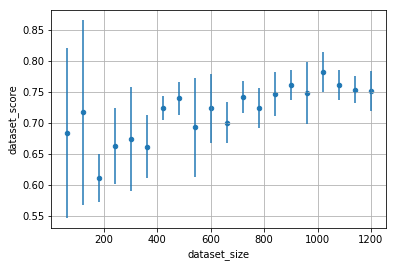

In [0]:
'''
Plot the data with standard deviation.
'''

import matplotlib.pyplot as plt

df.plot.scatter(x="dataset_size", y="dataset_score", yerr="dataset_score_std")
plt.grid(True)
plt.show()

In [0]:
'''
Select the data point until the accuracy increases linear.
'''

lin_datapoints = 1201.

df_smaller = df[df["dataset_size"] < lin_datapoints]
df_smaller

,dataset_size,dataset_score,dataset_score_std
0,60.0,0.683333,0.136931
1,120.0,0.716667,0.148488
2,180.0,0.611111,0.039284
3,240.0,0.662500,0.061449
4,300.0,0.673333,0.083832
5,360.0,0.661111,0.050651
6,420.0,0.723810,0.019561
7,480.0,0.739583,0.026557
8,540.0,0.692593,0.079490
9,600.0,0.723333,0.055715


In [0]:
model.fit(df_smaller["dataset_size"].to_numpy().reshape(-1,1), df_smaller["dataset_score"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

1200.0


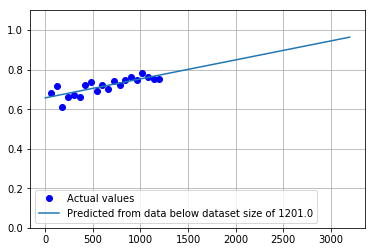

In [0]:
'''
Apply linear regression until the selected data point and plot the values.
'''

print(max(df['dataset_size'].tolist()))

x_model = np.array(range(int(max(df_smaller['dataset_size'].tolist()))+2000)).reshape(-1, 1)
y_model_pred = model.predict(x_model)

plt.plot(df["dataset_size"], df["dataset_score"], 'bo', label="Actual values") #, 'line type', label='label here')
label_ = "Predicted from data below dataset size of " + str(lin_datapoints)
plt.plot(x_model, y_model_pred, label=label_)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend(loc='best')